# Example 3: Using VBMC with PyMC models

In this notebook we show how to define a model in PyMC and the use VBMC to perform inference. For this example to work we need to have PyMC and ArviZ installed

In [1]:
import arviz as az
import numpy as np
import pymc as pm
from pyvbmc.vbmc import pymc_fit

In [2]:
az.style.use("arviz-white")

For the first example we are going to reproduce the [Rosenbrock's banana](https://en.wikipedia.org/wiki/Rosenbrock_function) in $D = 2$ from example 1, but this time using PyMC.

As the banana function is not available out-of-the-box from PyMC we have to write it ourselves.

In [3]:
def log_banana(x):
    return -pm.math.sum((x[0] ** 2.0 - x[1]) ** 2.0
                        + (x[0] - 1) ** 2.0 / 100)

This model do not have actual observed data, so we pass the `log_banana` function as a PyMC potential (an arbitrary term that we add to the log-likelihood term). We also define a prior as two independent $\mathcal{N}(0, 3)$ distributions, for convenience we define it as vector of size 2 using the `shape=2` argument.

In [4]:
with pm.Model() as model:
    x = pm.Normal("x", 0, 3, shape=2)
    y = pm.Potential("y", log_banana(x))
    vp, elbo, elbo_sd, idata = pymc_fit()

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action


/u/32/martino5/unix/proyectos/00_BM/pyvbmc/pyvbmc/vbmc/pymc_fit.py:192: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  result = pm.sample_prior_predictive(


     0         10           0.70         5.88     34645.41        2        inf     start warm-up
     1         15          -2.80         0.33         5.31        2        inf     
     2         20          -2.78         0.00         0.18        2       4.31     
     3         25          -2.81         0.00         0.07        2       1.86     
     4         30          -2.79         0.00         0.03        2      0.894     end warm-up
     5         35          -2.78         0.00         0.04        2      0.986     
     6         40          -2.75         0.00         0.03        2      0.843     
     7         45          -2.68         0.00         0.03        5       1.02     
     8         50          -2.59         0.00         0.02        6      0.875     rotoscale, undo
     9         55          -2.57         0.00         0.01        9      0.256     
    10         60          -2.54         0.00         0.01       12      0.251     
    11         65          -2.53     

Time to inspect the posterior, for a quick check of a few summary statistics we can do:

In [5]:
az.summary(idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
x[0],0.043,1.080,-1.958,1.822
x[1],1.117,1.343,-1.095,3.765


And because we are highly visual animals we also do a plot :-)

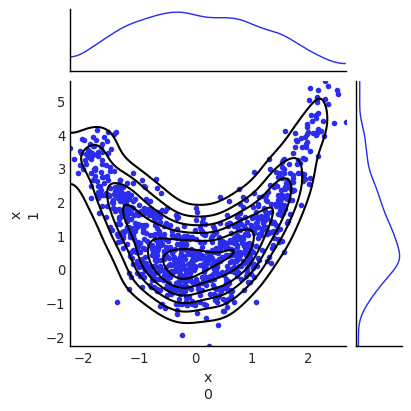

In [6]:
az.plot_pair(idata, marginals=True, kind=["kde", "scatter"], figsize=(4, 4));

Let us try with a diffent model, a Gaussian model with unkown mean and stantard deviation.

In [7]:
data = np.random.normal(0, 1, size=100)

with pm.Model() as model:
    a = pm.Normal("a", 0, 1)
    b = pm.HalfNormal("b", 1)
    y = pm.Normal("y", a, b, observed=data)
    vp, elbo, elbo_sd, idata = pymc_fit()

vbmc:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10        -156.34         7.14    376216.54        2        inf     start warm-up
     1         15        -156.96         0.07         0.75        2        inf     
     2         20        -156.87         0.00         0.12        2       3.07     
     3         25        -156.85         0.00         0.01        2      0.186     
     4         30        -156.85         0.00         0.00        2     0.0259     
     5         35        -156.85         0.00         0.01        2      0.315     
     6         40        -156.87         0.00         0.02        2       0.55     end warm-up
     7         45        -156.85         0.00         0.01        2       0.22     
     8         50

In [8]:
az.summary(idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a,-0.098,0.113,-0.317,0.104
b,1.129,0.075,1.004,1.254


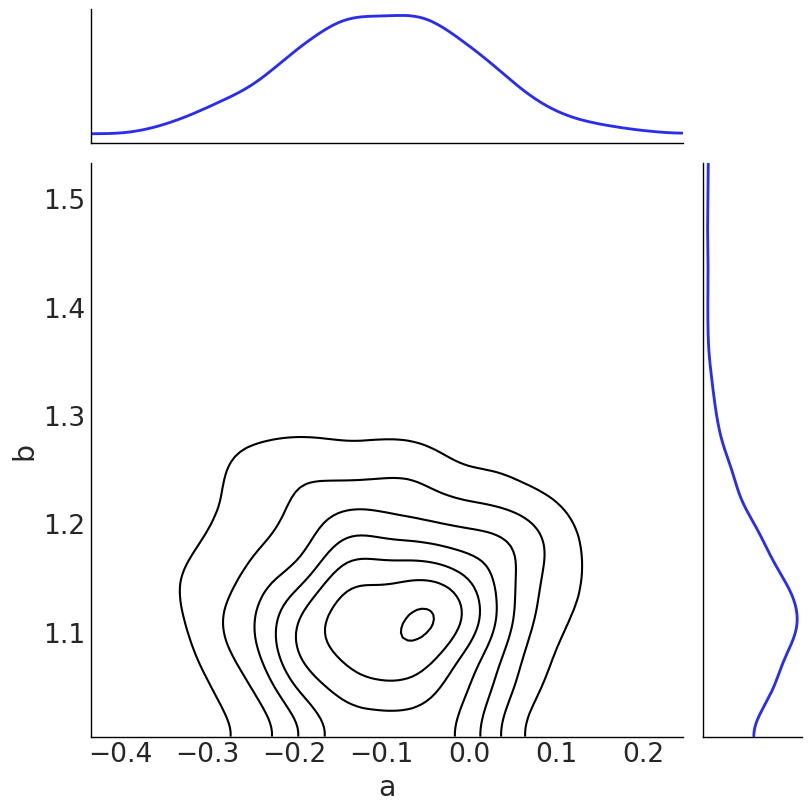

In [9]:
az.plot_pair(idata, marginals=True, kind=["kde"], figsize=(8, 8));

And continuing with the classics, a linear regression model with Gaussian response. In PyMC we can use deterministic variable to store intermediate results. The variable is deterministic in the sense that given its inputs the result is completelly determined.

In [10]:
x = np.random.normal(0, 1, size=100)
y = np.random.normal(x, 0.25)

with pm.Model() as model:
    α = pm.Normal("α", 0, 1)
    β = pm.Normal("β", 0, 1)
    σ = pm.HalfNormal("σ", 1)
    μ = pm.Deterministic("μ", α+β*x)
    obs = pm.Normal("obs", μ, σ, observed=y)
    vp, elbo, elbo_sd, idata = pymc_fit()

vbmc:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10        -112.44         5.74    823716.83        2        inf     start warm-up
     1         15        -106.24         0.31        77.41        2        inf     
     2         20        -105.81         0.04         0.12        2       3.85     
     3         25        -105.66         0.03         0.03        2       1.17     
     4         30        -105.66         0.01         0.01        2      0.205     
     5         35        -105.65         0.00         0.01        2      0.153     
     6         40        -105.66         0.00         0.00        2     0.0447     
     7         45        -105.68         0.00         0.00        2     0.0964     end warm-up
     8         50

Let's plot all variables except μ.

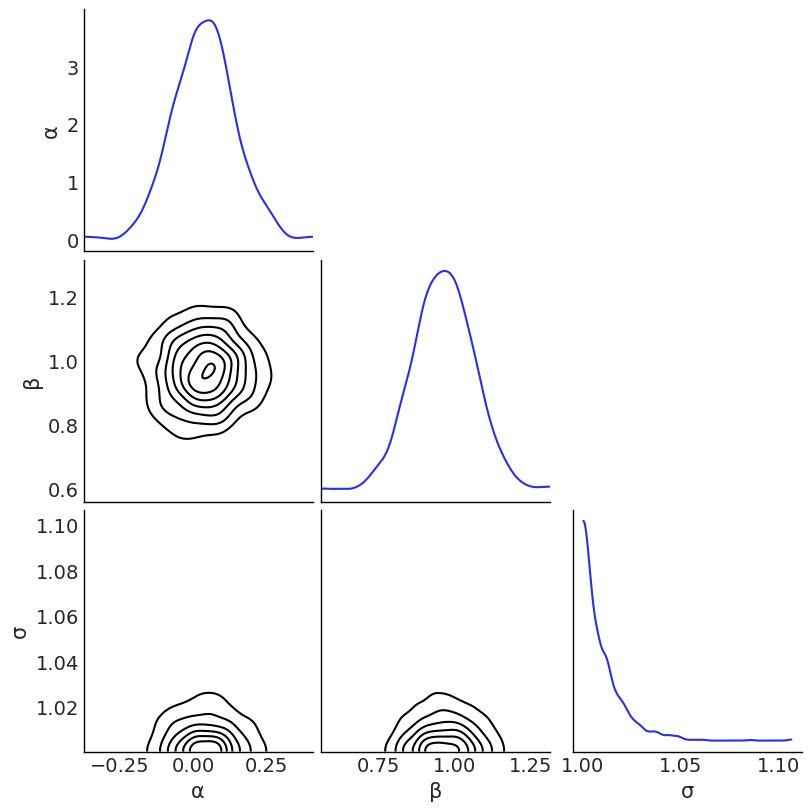

In [11]:
az.plot_pair(idata, marginals=True, var_names="~μ", kind=["kde"], figsize=(8, 8));

/u/32/martino5/unix/proyectos/00_BM/arviz/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


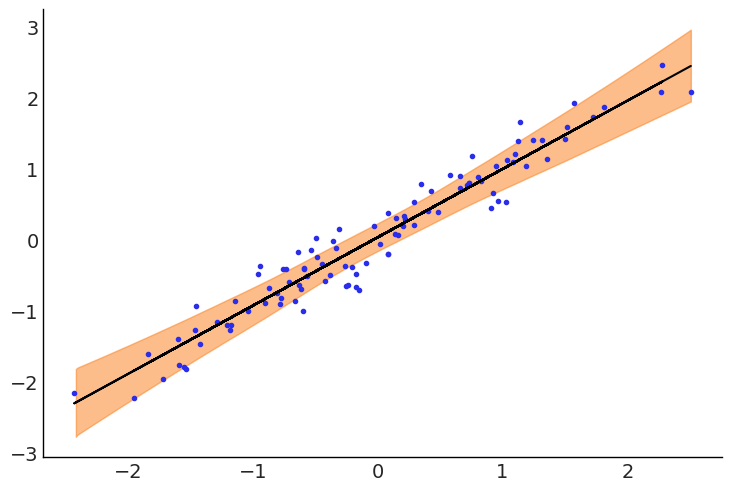

In [12]:
μ_samples = idata.posterior["μ"].squeeze()
ax = az.plot_hdi(x, μ_samples)
ax.plot(x, y, ".")
ax.plot(x, μ_samples.mean("draw"), "k");